# US Election 2020

In [1]:
import os
import zipfile
import pandas as pd
import numpy as np
import zipfile
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.decomposition import PCA
from sklearn.impute import KNNImputer
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Unzip and load the dataset
zip_file_path = 'US Election 2020.zip'
extracted_folder = 'US_Election_Data/'

# Unzipping the dataset
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_folder)

# Load the CSV file into a DataFrame
csv_file_path = extracted_folder + 'US_Election_dataset_v1.csv'
election_data = pd.read_csv(csv_file_path)

In [3]:
# Inspect the data
print("Initial Dataset Info:")
print(election_data.info())
print("\nInitial Dataset Description:")
print(election_data.describe())

Initial Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3143 entries, 0 to 3142
Data columns (total 35 columns):
 #   Column                                                                     Non-Null Count  Dtype  
---  ------                                                                     --------------  -----  
 0   Unnamed: 0                                                                 3143 non-null   object 
 1   county                                                                     3143 non-null   object 
 2   state                                                                      3143 non-null   object 
 3   2020 Democrat vote raw                                                     3143 non-null   int64  
 4   2020 Democrat vote %                                                       3143 non-null   float64
 5   2020 Republican vote raw                                                   3143 non-null   int64  
 6   2020 Republican vote %            

In [4]:
# Clean column names
election_data.columns = election_data.columns.str.strip()

In [5]:
# Check for missing values
print("\nMissing values per column:")
print(election_data.isnull().sum())


Missing values per column:
Unnamed: 0                                                                   0
county                                                                       0
state                                                                        0
2020 Democrat vote raw                                                       0
2020 Democrat vote %                                                         0
2020 Republican vote raw                                                     0
2020 Republican vote %                                                       0
2020 other vote raw                                                          0
2020 other vote %                                                            0
Population with less than 9th grade education                                0
Population with 9th to 12th grade education, no diploma                      0
High School graduate and equivalent                                          0
Some College,No Degree  

In [9]:
# Handle outliers using Z-scores
def cap_outliers(df, cols, threshold=3):
    """
    Cap outliers using Z-scores by replacing outliers with the column's max/min value.
    """
    from scipy.stats import zscore
    
    # Ensure columns are cleaned and match exact names
    df.columns = df.columns.str.strip().str.replace(' ', '_')

    for col in cols:
        if col in df.columns:
            # Calculate Z-scores for the column
            z_scores = zscore(df[col].apply(pd.to_numeric, errors='coerce'))  # Convert to numeric to avoid errors

            # Cap outliers by Z-score threshold
            df[col] = np.where(z_scores > threshold, df[col].max(), df[col])
            df[col] = np.where(z_scores < -threshold, df[col].min(), df[col])
        else:
            print(f"Column '{col}' not found in the dataframe.")

    return df

# Example usage: Cap outliers for relevant numeric columns
outlier_columns = ['2020_Democrat_vote_raw', '2020_Republican_vote_raw', '2020_other_vote_raw', 
                   'Population_with_less_than_9th_grade_education', 'Median_income_(dollars)', 'Mean_income_(dollars)']

election_data = cap_outliers(election_data, outlier_columns)

# Check for changes
print("\nAfter capping outliers, dataset info:")
print(election_data.info())


After capping outliers, dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3143 entries, 0 to 3142
Data columns (total 35 columns):
 #   Column                                                                     Non-Null Count  Dtype  
---  ------                                                                     --------------  -----  
 0   Unnamed:_0                                                                 3143 non-null   object 
 1   county                                                                     3143 non-null   object 
 2   state                                                                      3143 non-null   object 
 3   2020_Democrat_vote_raw                                                     3143 non-null   int64  
 4   2020_Democrat_vote_%                                                       3143 non-null   float64
 5   2020_Republican_vote_raw                                                   3143 non-null   int64  
 6   2020_Republican_v

In [11]:
# Feature Engineering
election_data['total_votes'] = (
    election_data['2020_Democrat_vote_raw'] +
    election_data['2020_Republican_vote_raw'] +
    election_data['2020_other_vote_raw']
)

election_data['vote_share_democrat'] = (
    election_data['2020_Democrat_vote_raw'] / election_data['total_votes']
) * 100

election_data['vote_share_republican'] = (
    election_data['2020_Republican_vote_raw'] / election_data['total_votes']
) * 100

election_data['vote_share_diff'] = (
    election_data['vote_share_democrat'] - election_data['vote_share_republican']
)


Transformed Columns:
   Median_income_(dollars)  Total_Population
0                11.131899         10.981999
1                11.170998         12.353492
2                10.589434         10.135551
3                10.833089         10.012073
4                10.958514         10.987578


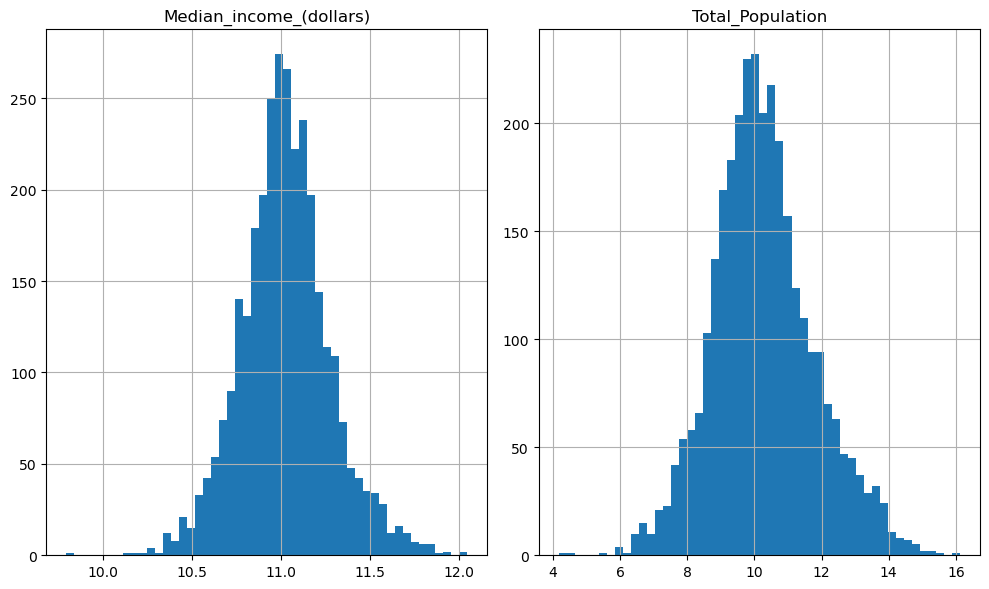

In [14]:
# Data Transformation
# Handle non-numeric entries in the skewed columns
skewed_cols = ['Median_income_(dollars)', 'Total_Population']

for col in skewed_cols:
    # Remove non-numeric characters (e.g., commas, dollar signs)
    election_data[col] = election_data[col].replace({',': '', '\$': ''}, regex=True)
    
    # Convert the column to numeric, coercing errors to NaN
    election_data[col] = pd.to_numeric(election_data[col], errors='coerce')
    
    # Fill missing values with the median of the column
    election_data[col].fillna(election_data[col].median(), inplace=True)

# Apply log1p transformation
for col in skewed_cols:
    # Before transformation, ensure the column contains no negative values
    if (election_data[col] < 0).any():
        print(f"Warning: Negative values detected in {col}. Consider handling them.")
    election_data[col] = np.log1p(election_data[col])

# Verify transformation
print("\nTransformed Columns:")
print(election_data[skewed_cols].head())

# Optionally, visualize the distribution of transformed columns
import seaborn as sns
election_data[skewed_cols].hist(bins=50, figsize=(10, 6))
plt.tight_layout()
plt.show()

In [15]:
# Normalize numerical columns
scaler = StandardScaler()

# Select only numeric columns for PCA
numeric_cols = election_data.select_dtypes(include=[np.number]).columns.tolist()
election_data[numeric_cols] = scaler.fit_transform(election_data[numeric_cols])

In [16]:
# Feature Selection for PCA
# Drop non-numeric or irrelevant columns
X = election_data[numeric_cols].drop(columns=['vote_share_democrat'], errors='ignore')
y = election_data['vote_share_democrat']

# Step 10: PCA Transformation
pca = PCA(n_components=0.95)  # Retain 95% variance
X_pca = pca.fit_transform(X)

print(f"\nPCA reduced to {X_pca.shape[1]} components.")


PCA reduced to 17 components.


In [17]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)


Linear Regression Evaluation:
Mean Absolute Error (MAE): 0.0358
Mean Squared Error (MSE): 0.0082
R-squared (R2): 0.9918


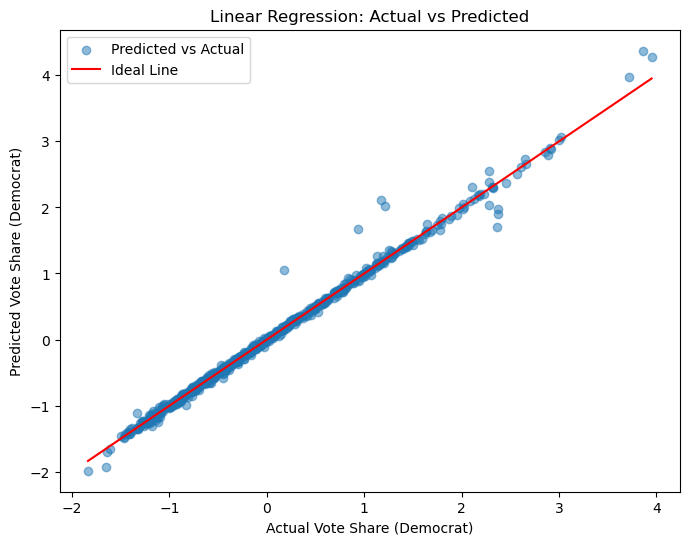


Ridge Regression Evaluation:
Mean Absolute Error (MAE): 0.0357
Mean Squared Error (MSE): 0.0082
R-squared (R2): 0.9918


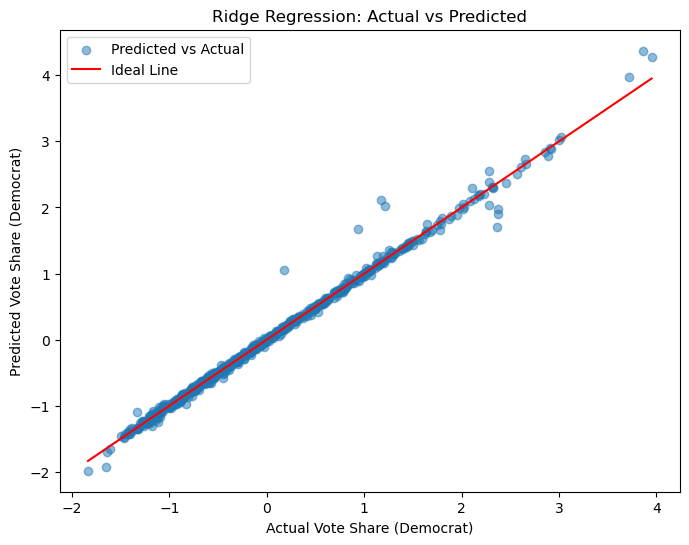


Lasso Regression Evaluation:
Mean Absolute Error (MAE): 0.1997
Mean Squared Error (MSE): 0.0689
R-squared (R2): 0.9306


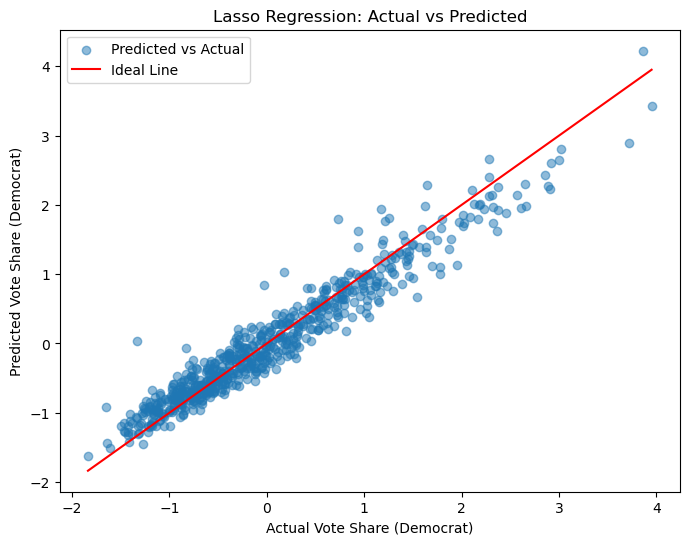


Random Forest Regressor Evaluation:
Mean Absolute Error (MAE): 0.1274
Mean Squared Error (MSE): 0.0324
R-squared (R2): 0.9673


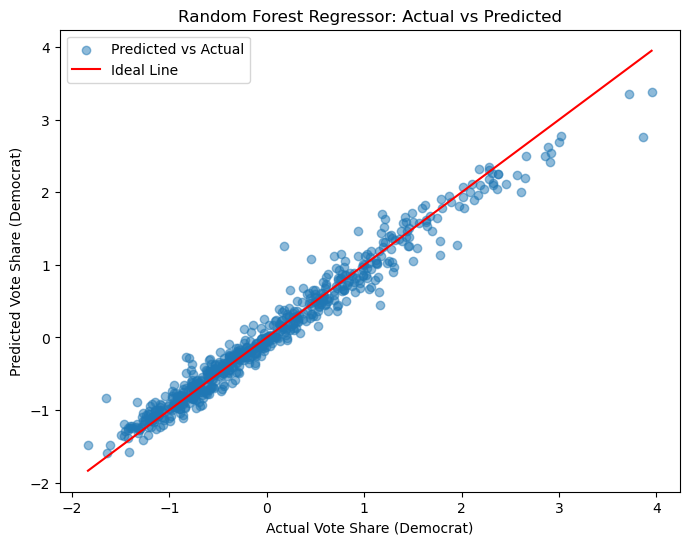

In [18]:
# Train and Evaluate Models
# Initialize models
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "Lasso Regression": Lasso(alpha=0.1),
    "Random Forest Regressor": RandomForestRegressor(n_estimators=100, random_state=42)
}

for model_name, model in models.items():
    # Train model
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Evaluate model
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"\n{model_name} Evaluation:")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"R-squared (R2): {r2:.4f}")

    # Plot Actual vs Predicted
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.5, label="Predicted vs Actual")
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', label="Ideal Line")
    plt.title(f"{model_name}: Actual vs Predicted")
    plt.xlabel("Actual Vote Share (Democrat)")
    plt.ylabel("Predicted Vote Share (Democrat)")
    plt.legend()
    plt.show()

In [19]:
# Cross-Validation for Random Forest
rf_model = models["Random Forest Regressor"]
cv_scores = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='r2')
print(f"\nRandom Forest Cross-Validation R2 Scores: {cv_scores}")
print(f"Average R2 Score: {np.mean(cv_scores):.4f}")


Random Forest Cross-Validation R2 Scores: [0.94936774 0.96181483 0.94859416 0.96286985 0.96569498]
Average R2 Score: 0.9577


In [ ]:
# Exploratory Data Analysis

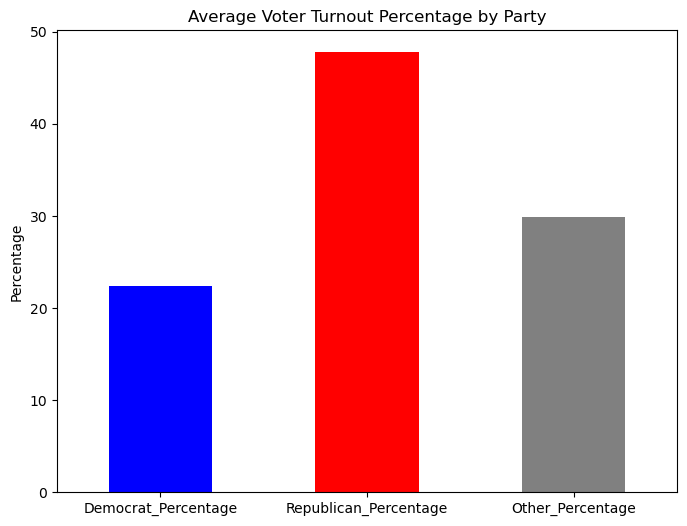

In [21]:
# Voter Turnout by Party

# Calculate total votes and vote percentage
election_data['Total_Votes'] = (election_data['2020_Democrat_vote_raw'] + 
                                election_data['2020_Republican_vote_raw'] + 
                                election_data['2020_other_vote_raw'])

election_data['Democrat_Percentage'] = (election_data['2020_Democrat_vote_raw'] / election_data['Total_Votes']) * 100
election_data['Republican_Percentage'] = (election_data['2020_Republican_vote_raw'] / election_data['Total_Votes']) * 100
election_data['Other_Percentage'] = (election_data['2020_other_vote_raw'] / election_data['Total_Votes']) * 100

# Average percentages
average_percentages = election_data[['Democrat_Percentage', 'Republican_Percentage', 'Other_Percentage']].mean()

# Plot
average_percentages.plot(kind='bar', color=['blue', 'red', 'gray'], figsize=(8, 6))
plt.title('Average Voter Turnout Percentage by Party')
plt.ylabel('Percentage')
plt.xticks(rotation=0)
plt.show()

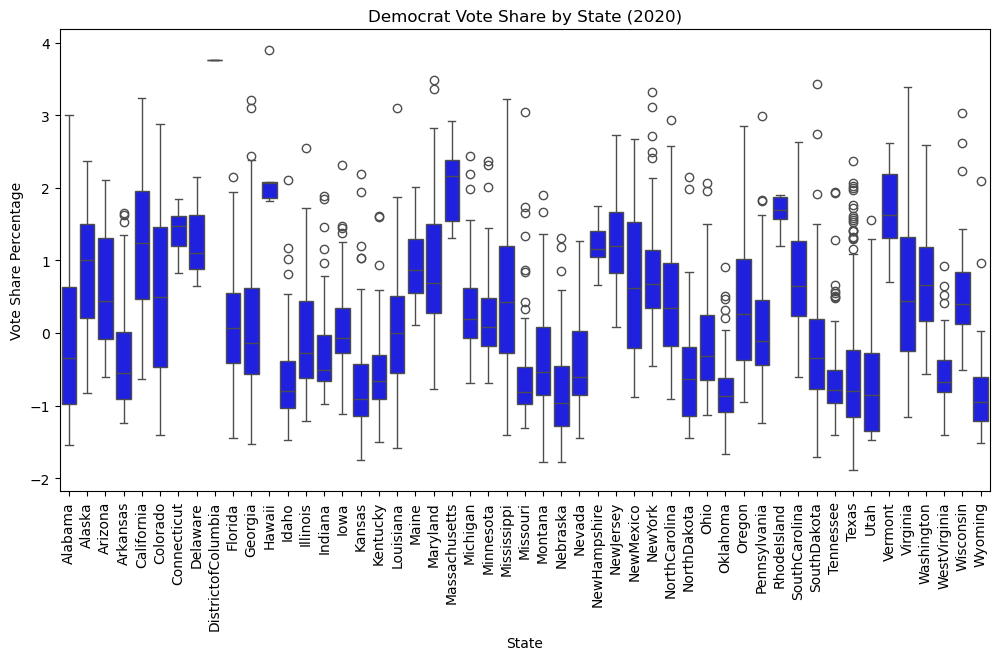

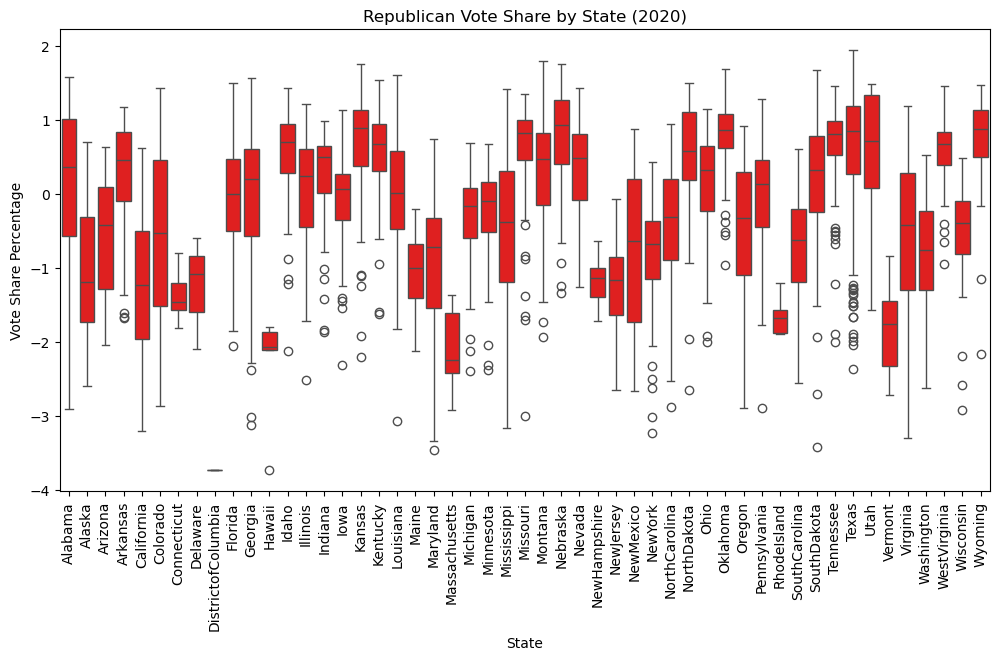

In [33]:
# Vote Share by State

plt.figure(figsize=(12, 6))
sns.boxplot(data=election_data, x='state', y='2020_Democrat_vote_%', color='blue')
plt.title('Democrat Vote Share by State (2020)')
plt.xticks(rotation=90)
plt.ylabel('Vote Share Percentage')
plt.xlabel('State')
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(data=election_data, x='state', y='2020_Republican_vote_%', color='red')
plt.title('Republican Vote Share by State (2020)')
plt.xticks(rotation=90)
plt.ylabel('Vote Share Percentage')
plt.xlabel('State')
plt.show()

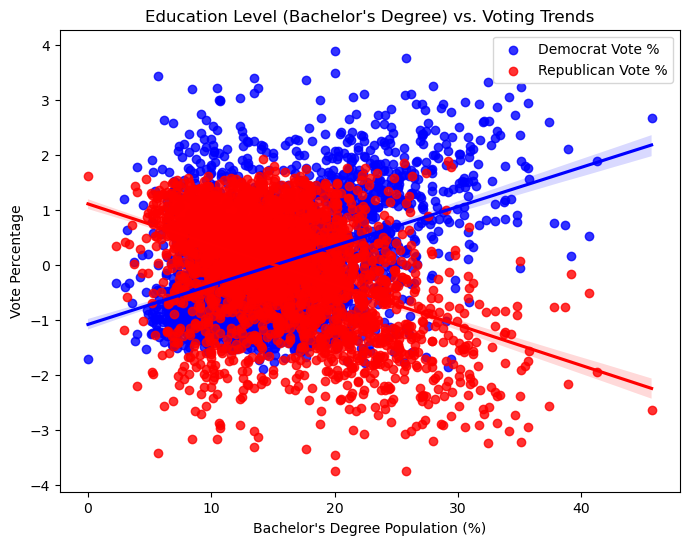

In [38]:
# Education Level vs. Voting Trends

# Convert education levels to numeric if necessary
education_columns = [
    'Population_with_less_than_9th_grade_education',
    'Population_with_9th_to_12th_grade_education,_no_diploma', 
    'High_School_graduate_and_equivalent', 
    'Some_College,No_Degree', 'Associates_Degree', 
    'Bachelors_Degree', 'Graduate_or_professional_degree'
]

# Ensure percentage columns are properly cleaned
for col in education_columns:
    election_data[col] = election_data[col].str.replace('%', '').astype(float)

# Plot
plt.figure(figsize=(8, 6))
sns.regplot(data=election_data, x='Bachelors_Degree', y='2020_Democrat_vote_%', color='blue', label='Democrat Vote %')
sns.regplot(data=election_data, x='Bachelors_Degree', y='2020_Republican_vote_%', color='red', label='Republican Vote %')
plt.title('Education Level (Bachelor\'s Degree) vs. Voting Trends')
plt.xlabel('Bachelor\'s Degree Population (%)')
plt.ylabel('Vote Percentage')
plt.legend()
plt.show()

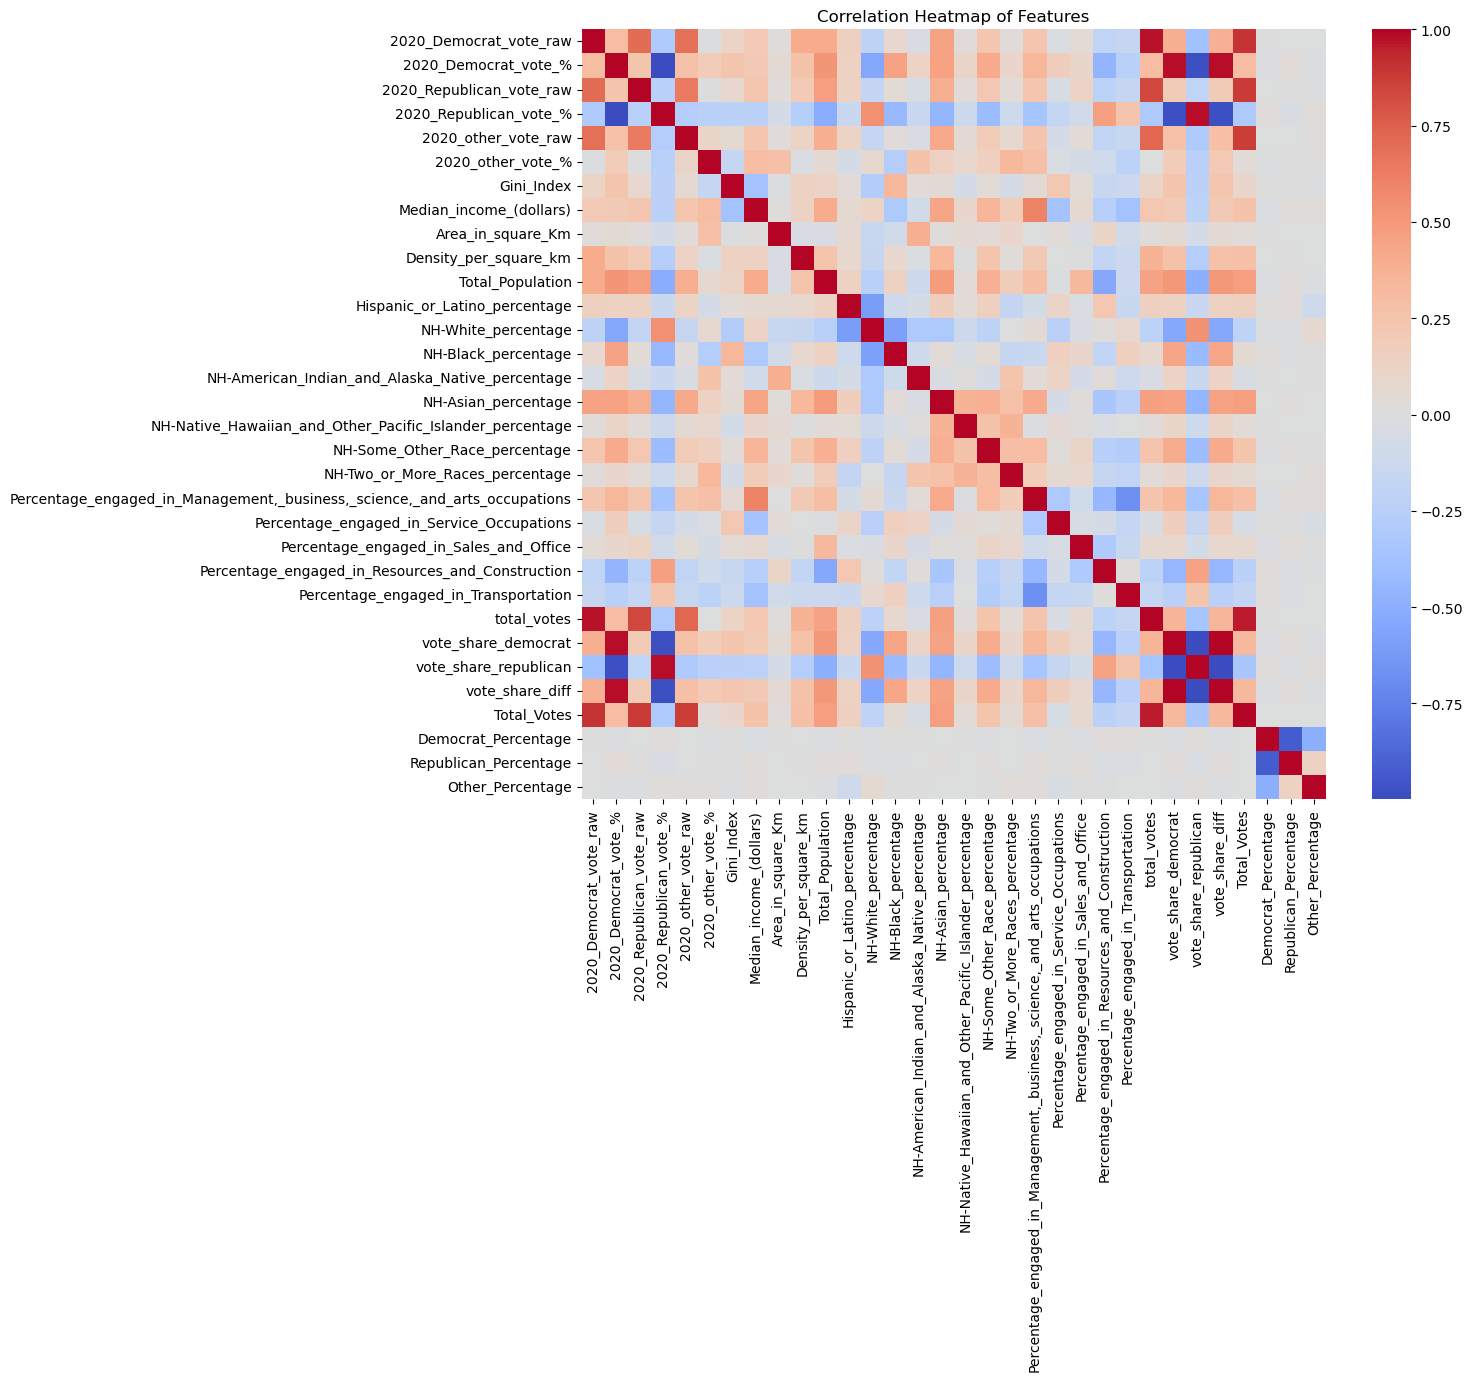

In [25]:
# Correlation Heatmap

# Select relevant numeric columns
numeric_cols = election_data.select_dtypes(include=['float64', 'int64']).columns

# Correlation matrix
corr_matrix = election_data[numeric_cols].corr()

# Heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Features')
plt.show()

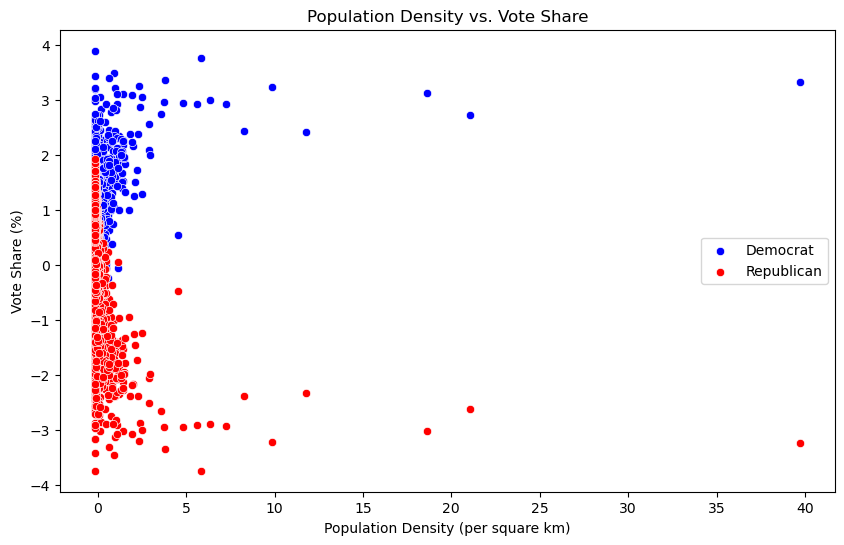

In [39]:
# Population Density and Vote Share
plt.figure(figsize=(10, 6))
sns.scatterplot(data=election_data, x='Density_per_square_km', y='2020_Democrat_vote_%', color='blue', label='Democrat')
sns.scatterplot(data=election_data, x='Density_per_square_km', y='2020_Republican_vote_%', color='red', label='Republican')
plt.title('Population Density vs. Vote Share')
plt.xlabel('Population Density (per square km)')
plt.ylabel('Vote Share (%)')
plt.legend()
plt.show()

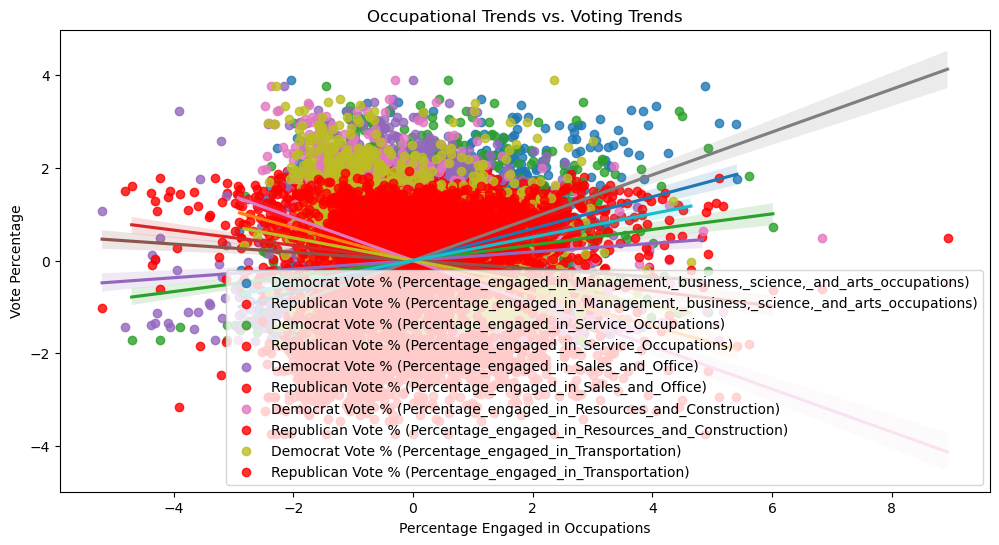

In [40]:
# Occupational Trends (example for Percentage engaged in various occupations)
occupational_columns = [
    'Percentage_engaged_in_Management,_business,_science,_and_arts_occupations',
    'Percentage_engaged_in_Service_Occupations',
    'Percentage_engaged_in_Sales_and_Office',
    'Percentage_engaged_in_Resources_and_Construction',
    'Percentage_engaged_in_Transportation'
]

# Plot
plt.figure(figsize=(12, 6))
for col in occupational_columns:
    sns.regplot(data=election_data, x=col, y='2020_Democrat_vote_%', label=f'Democrat Vote % ({col})')
    sns.regplot(data=election_data, x=col, y='2020_Republican_vote_%', label=f'Republican Vote % ({col})', scatter_kws={'color':'red'})

plt.title('Occupational Trends vs. Voting Trends')
plt.xlabel('Percentage Engaged in Occupations')
plt.ylabel('Vote Percentage')
plt.legend()
plt.show()

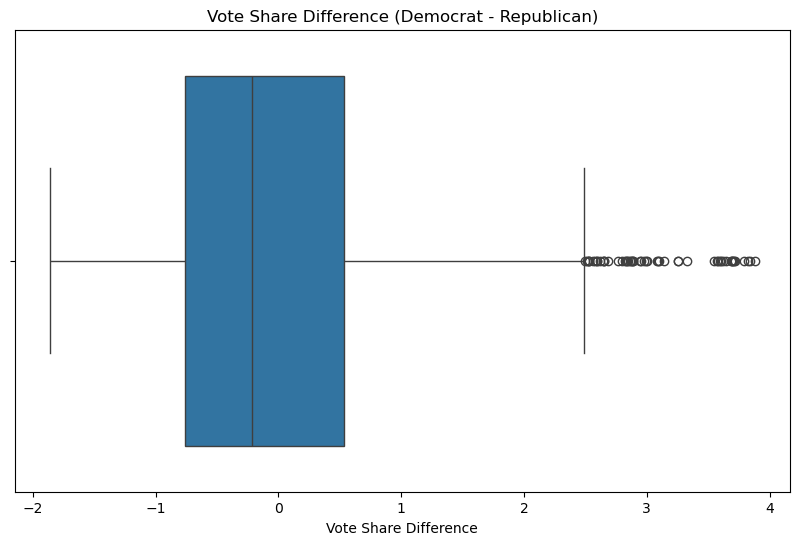

In [28]:
# Vote Share Difference (Democrat vs Republican)

plt.figure(figsize=(10, 6))
sns.boxplot(x=election_data['vote_share_diff'])
plt.title('Vote Share Difference (Democrat - Republican)')
plt.xlabel('Vote Share Difference')
plt.show()